# Standardize output data
Run these cells sequentially

In [1]:
# Import necessary modules
import os
from utils import *
import utils.for_setpath as path

c:\Users\joaop\git\emotional-cities\notebooks\.conda\Lib\site-packages\heartpy\datautils.py:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_filename


# Run analysis

#### Within-subject

In [2]:
results_dir = os.path.join(path.results, 'fulldata')
design = 'within_subject'
sub = 'OE011'
ses = 'Baixa'
sub_data = do_analysis_design(results_dir, design, subject=sub, session=ses)

Could not load geodatasets 'world' shapefile. Using local fallback or skip background map.


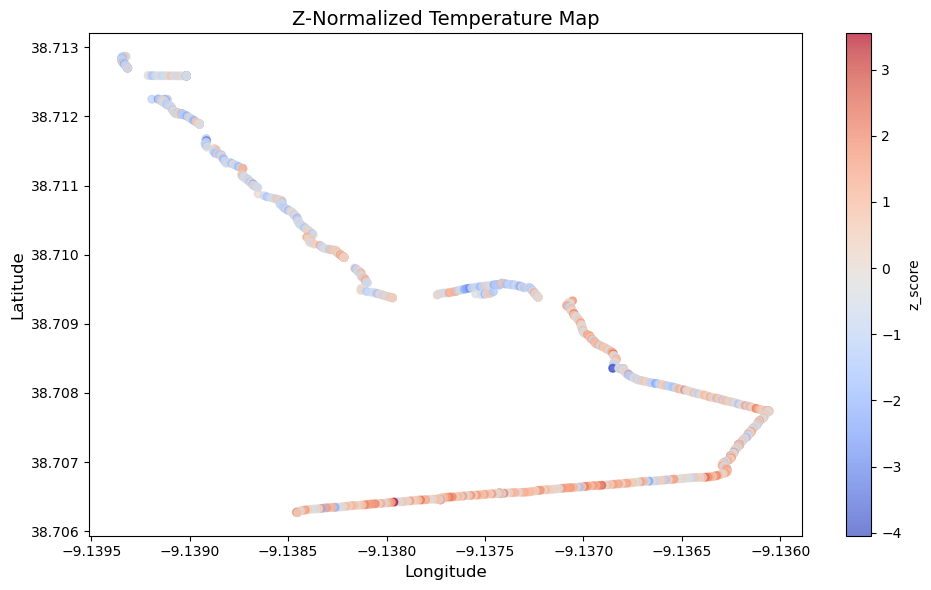

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# If you want to use geodatasets, install first:
#    pip install geodatasets
# Then:
import geodatasets
from shapely.geometry import Point

def plot_z_normalized_map(data, variable, lon_col, lat_col, title):
    """
    Plot z-normalized values of a specific variable on a map based on longitude and latitude.
    
    Args:
        data (pd.DataFrame): Data containing the variable, longitude, and latitude columns.
        variable (str): The column name of the variable to be plotted.
        lon_col (str): The column name for longitude values.
        lat_col (str): The column name for latitude values.
        title (str): The title of the plot.
    """
    # Safety checks
    if variable not in data.columns:
        print(f"Warning: variable '{variable}' not found in data.")
        return
    if lon_col not in data.columns or lat_col not in data.columns:
        print(f"Warning: columns '{lon_col}' or '{lat_col}' not found in data.")
        return

    # Drop rows with missing lat/lon or variable
    sub_data = data.dropna(subset=[variable, lon_col, lat_col])
    if sub_data.empty:
        print("No valid rows after dropping NaN lat/lon/variable. Nothing to plot.")
        return

    # Calculate z-scores
    mean_val = sub_data[variable].mean()
    std_val  = sub_data[variable].std()
    if std_val == 0 or np.isnan(std_val):
        print("Standard deviation is zero or NaN, cannot compute z-score. Plotting raw values.")
        sub_data['z_score'] = sub_data[variable]
    else:
        sub_data['z_score'] = (sub_data[variable] - mean_val) / std_val

    # Create geometry from lon/lat
    sub_data['geometry'] = [Point(xy) for xy in zip(sub_data[lon_col], sub_data[lat_col])]
    gdf = gpd.GeoDataFrame(sub_data, geometry='geometry', crs="EPSG:4326")  # typical lat/lon

    # -----------------------------------------------------------------
    # Option A) Using geodatasets:
    #   "geoda.natural_earth.cultural.lowres_110" is a 1:110m scale
    #   boundary set for countries.
    # -----------------------------------------------------------------
    try:
        world_path = geodatasets.get_path("geoda.natural_earth.cultural.lowres_110")
        world = gpd.read_file(world_path)
    except Exception as e:
        print("Could not load geodatasets 'world' shapefile. Using local fallback or skip background map.")
        world = None

    # -----------------------------------------------------------------
    # Option B) Using an online GeoJSON if no geodatasets are available:
    #
    #  geojson_url = "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json"
    #  world = gpd.read_file(geojson_url)
    # -----------------------------------------------------------------

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))

    if world is not None:
        world.plot(ax=ax, color='lightgrey', edgecolor='white')

    # Plot points, color-coded by z_score
    # If you want a continuous color scale, use 'scheme=None' and specify 'cmap'.
    sub_data.plot(  # or gdf directly
        ax=ax, 
        x=lon_col, y=lat_col,   # or rely on geometry= for a gdf
        kind='scatter', 
        c='z_score', 
        cmap='coolwarm', 
        alpha=0.7,
        s=30,
        legend=True
    )

    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Longitude", fontsize=12)
    ax.set_ylabel("Latitude", fontsize=12)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
# Example usage:
# sub_data = your_dataframe_here
# plot_z_normalized_map(sub_data, variable='alpha', lon_col='longitude', lat_col='latitude',
#                       title='Z-Normalized Alpha Plot')


plot_z_normalized_map(sub_data, variable='frontal alpha asymmetry', lon_col='longitude', lat_col='latitude', title='Z-Normalized Temperature Map')


#### Betweeen-subject

In [ ]:
results_dir = os.path.join(path.results, 'fulldata')
design = 'between_subject'
between_subject_data = do_analysis_design(results_dir, design)
# Export
results_dir = os.path.join(path.results, 'fulldata')
output_dir  = os.path.join(path.results, 'fulldata_analysis',design)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
between_subject_data.to_csv(os.path.join(output_dir, 'between_subject.csv'), index=False)

In [23]:
# Do correlation between variables

import os
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt

#############################################
# 1) Define your sets of variables
#############################################
PHYSIO_VARS = [
    # EEG variables
    "delta","theta","alpha","beta","gamma","frontal alpha","frontal midline theta",
    "theta-beta ratio","frontal alpha asymmetry","frontal theta",
    # Empatica variables
    "empatica_heart_rate","empatica_e4_ibi",
    "skin_temperature","eda_raw","eda_phasic","x_acceleration","y_acceleration","z_acceleration",
    "acceleration_magnitude","bvp"
]

CLIMATE_VARS = [
    "air_temperature","air_humidity","air_pressure","sound_pressure_level",
    "humidity_sensor","pm2_5","pm10_0","solar_light","thermocouple_temp",
    "north_wind","east_wind","gust_wind","atmospheric_temperature","humidity",
    "wind_speed","radiant_temp","utci","pressure",
    # Add or remove columns as you see fit
]

def compute_physio_climate_correlations(df, phys_vars, clim_vars, alpha=0.05):
    """
    Compute Pearson correlations (r, p) between each variable in phys_vars and each in clim_vars.
    Returns:
      corr_r: DataFrame of correlation coefficients, shape=(len(phys_vars), len(clim_vars))
      corr_p: DataFrame of p-values, same shape
      mask: boolean DataFrame, True if p < alpha => for plotting masked significant correlations
    """
    # Filter actual columns that exist in df
    phys_available = [col for col in phys_vars if col in df.columns]
    clim_available = [col for col in clim_vars if col in df.columns]

    # Initialize arrays for r and p
    r_values = np.zeros((len(phys_available), len(clim_available)), dtype=float)
    p_values = np.ones((len(phys_available), len(clim_available)), dtype=float)

    for i, pcol in enumerate(phys_available):
        for j, ccol in enumerate(clim_available):
            subdata = df[[pcol, ccol]].dropna()
            if len(subdata) > 2:
                r, p = pearsonr(subdata[pcol], subdata[ccol])
                r_values[i, j] = r
                p_values[i, j] = p
            else:
                r_values[i, j] = np.nan
                p_values[i, j] = np.nan

    corr_r = pd.DataFrame(r_values, index=phys_available, columns=clim_available)
    corr_p = pd.DataFrame(p_values, index=phys_available, columns=clim_available)

    # Create a mask for significance
    mask_significant = corr_p < alpha
    return corr_r, corr_p, mask_significant

def plot_correlation_matrix(corr_r, corr_p, mask, title, out_png):
    """
    Plot a heatmap of the correlation coefficients (corr_r).
    Then a second figure with a masked correlation map for significance.
    Save them to out_png + suffix.
    """
    # 1) Full correlation matrix
    plt.figure(figsize=(12,6))
    sns.heatmap(corr_r, annot=False, cmap="coolwarm", center=0, vmin=-1, vmax=1)
    plt.title(f"{title} - Full Correlation Matrix")
    plt.tight_layout()
    plt.savefig(out_png.replace('.png', '_full.png'), dpi=150)
    plt.close()

    # 2) Masked correlation matrix: we only show r-values where p < alpha
    #    Typically done by putting NaN on nonsignificant entries, or using a seaborn mask
    masked_corr = corr_r.where(mask, np.nan)
    plt.figure(figsize=(12,6))
    # If you want a simple 'where p<alpha => show', we can just plot masked with the same bounds
    sns.heatmap(masked_corr, annot=False, cmap="coolwarm", center=0, vmin=-1, vmax=1)
    plt.title(f"{title} - Only Significant Correlations (p < 0.05)")
    plt.tight_layout()
    plt.savefig(out_png.replace('.png', '_masked.png'), dpi=150)
    plt.close()

# MAIN
# data_csv_path = r"path\to\your\table.csv"
# df = pd.read_csv(data_csv_path)

# Compute correlation
corr_r, corr_p, mask_sig = compute_physio_climate_correlations(between_subject_data, PHYSIO_VARS, CLIMATE_VARS, alpha=0.05)

corr_r.to_csv(os.path.join(output_dir, "physio_climate_corr_r.csv"))
corr_p.to_csv(os.path.join(output_dir, "physio_climate_corr_p.csv"))

# Plot
plot_correlation_matrix(corr_r, corr_p, mask_sig, title="Physio vs. Climate", 
                        out_png=os.path.join(output_dir, "physio_climate_correlation.png"))
print("Done: correlation matrices exported and plots saved.")


Done: correlation matrices exported and plots saved.


In [ ]:
# Check differences between age groups

#### Within-path

In [10]:
results_dir = os.path.join(path.results, 'fulldata')
design = 'within_path'
ses = 'Baixa'
data = do_analysis_design(results_dir, design, session=ses)
# Export
results_dir = os.path.join(path.results, 'fulldata')
output_dir  = os.path.join(path.results, 'fulldata_analysis',design, ses)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
data.to_csv(os.path.join(output_dir, f'{ses}.csv'), index=False)

In [ ]:
# Plot z-no

#### Between-path

In [ ]:
results_dir = os.path.join(path.results, 'fulldata')
design = 'between_path'
ses = ['Baixa', 'Graca','Parque','Lapa','Gulbenkian','Belem']
data = do_analysis_design(results_dir, design, session=ses)
# Export
results_dir = os.path.join(path.results, 'fulldata')
output_dir  = os.path.join(path.results, 'fulldata_analysis',design)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
data.to_csv(os.path.join(output_dir, f'main_paths.csv'), index=False)

In [ ]:
# Plot data onto map
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

def plot_paths_on_map(combined_df, vars_to_plot, output_dir):
    """
    Create subplots for each path in 'session_path',
    coloring points by a chosen variable (one figure per variable).

    combined_df: pd.DataFrame with columns:
        - longitude, latitude (floats)
        - session_path (string)
        - numeric columns to be plotted
    vars_to_plot: list of string column names to visualize
    output_dir: folder to save the generated figures
    """

    # 1) Convert to GeoDataFrame for easy plotting
    #    If you don't have geopandas, skip this & plot with plain matplotlib scatter
    gdf = gpd.GeoDataFrame(
        combined_df.copy(),
        geometry=gpd.points_from_xy(combined_df['longitude'], combined_df['latitude']),
        crs="EPSG:4326"  # typical lat/lon
    )

    # 2) Identify unique paths
    paths = gdf["session_path"].unique()
    paths = np.sort(paths)  # for consistent ordering

    # 3) For each variable in vars_to_plot => single figure => subplots for each path
    for var in vars_to_plot:
        # a) create figure with one row per path, or do 1 x len(paths)
        fig, axes = plt.subplots(
            1, len(paths),
            figsize=(5 * len(paths), 6),
            subplot_kw={'aspect': 'equal'}  # maintain aspect ratio
        )
        # If there's only one path, axes won't be an array
        if len(paths) == 1:
            axes = [axes]

        for i, path_ in enumerate(paths):
            ax = axes[i]
            # Filter data for this path
            sub_gdf = gdf.loc[gdf["session_path"] == path_]

            # b) plot
            # If the var has NaN, you might want to skip or fill them
            sub_gdf = sub_gdf.dropna(subset=[var])

            # Plot points, color by var
            # we can let GeoPandas handle the color mapping via 'column=var'
            # legend=True => colorbar
            # markersize => for better visibility
            if not sub_gdf.empty:
                sub_gdf.plot(
                    column=var,
                    cmap='viridis',
                    legend=True,
                    markersize=30,
                    alpha=0.8,
                    ax=ax
                )
            else:
                ax.text(0.5, 0.5, "No data", ha='center', va='center', transform=ax.transAxes)
            
            # c) titles, etc.
            ax.set_title(f"{path_}: {var}", fontsize=12)
            ax.set_xlabel("Longitude")
            ax.set_ylabel("Latitude")

        plt.suptitle(f"Map of {var} by Path", fontsize=15, y=1.02)
        plt.tight_layout()
        # d) Save figure
        out_fname = os.path.join(output_dir, f"{var}_map_all_paths.png")
        plt.savefig(out_fname, dpi=150, bbox_inches='tight')
        plt.close(fig)


numeric_variables = ["beta"]  # adapt to your data

# Demo: read a CSV
# combined_df = pd.read_csv(r"path\to\your\between_path_result.csv")

# Now call the function
plot_paths_on_map(data, numeric_variables, output_dir)

print("Plots generated for each variable, subplots per path.")